# Solve for $N_g$ in the Transcendental Equation
This notebook numerically solves for $N_g$ in
$$
\ln(1-\epsilon)[\alpha e^{-f}+\beta e^{-\kappa N_g}+E_{\mathrm{gs}}]= -\alpha e^{-f}\mu_0\Delta\left[\frac{N_g(1+\lambda)-100}{N_g^2(N_g-100)^{\lambda+1}}\right]+\beta\kappa e^{-\kappa N_g}.
$$

## 1) Define Parameters and Equation
Set constants and restate the equation to solve for $N_g$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import root_scalar, fsolve, minimize_scalar

# Parameters (edit these)
params = {
    "epsilon": 1e-5,
    "alpha": 2.0,
    "beta": 4.0,
    "kappa": 1e-2,
    "E_gs": -7.711545013271975,
    "mu0": 0.78,
    "Delta": 5e4,
    "lam": 0.58,
}

params

{'epsilon': 1e-05,
 'alpha': 2.0,
 'beta': 4.0,
 'kappa': 0.01,
 'E_gs': -7.711545013271975,
 'mu0': 0.78,
 'Delta': 50000.0,
 'lam': 0.58}

## 2) Implement Residual Function
The residual is LHS - RHS. We enforce $N_g>100$ and $1-\epsilon>0$.

In [13]:
def residual_ng(Ng, p):
    eps = p["epsilon"]
    alpha = p["alpha"]
    beta = p["beta"]
    kappa = p["kappa"]
    E_gs = p["E_gs"]
    mu0 = p["mu0"]
    Delta = p["Delta"]
    lam = p["lam"]

    if Ng <= 100:
        return np.nan
    if 1 - eps <= 0:
        return np.nan

    # f(N_g) = mu0 * Delta / (N_g * (N_g - 100)^lam)
    f_ng = (mu0 * Delta) / (Ng * (Ng - 100) ** lam)

    lhs = np.log(1 - eps) * (alpha * np.exp(-f_ng) + beta * np.exp(-kappa * Ng) + E_gs)
    rhs = -alpha * np.exp(-f_ng) * mu0 * Delta * (
        (Ng * (1 + lam) - 100) / (Ng**2 * (Ng - 100) ** (lam + 1))
    ) + beta * kappa * np.exp(-kappa * Ng)

    return lhs - rhs

# quick check
residual_ng(200.0, params)

-0.005341305732376157

## 3) Solve for $N_g$ with Root Finding
We scan for a sign change to bracket a root, then use `root_scalar`. If no bracket is found, we fall back to `fsolve`.

In [14]:
def find_bracket(p, ng_min=110.0, ng_max=1.0e8, n_scan=300):
    grid = np.logspace(np.log10(ng_min), np.log10(ng_max), n_scan)
    res = np.array([residual_ng(x, p) for x in grid])

    bracket = None
    for i in range(len(grid) - 1):
        a, b = grid[i], grid[i + 1]
        fa, fb = res[i], res[i + 1]
        if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
            bracket = (a, b)
            break

    return grid, res, bracket

# Find a bracket over a wide range
Ng_grid, res_grid, bracket = find_bracket(params)

if bracket:
    sol = root_scalar(lambda x: residual_ng(x, params), bracket=bracket, method="brentq")
    Ng_root = sol.root if sol.converged else np.nan
    method_used = "brentq"
else:
    # Fallback: minimize absolute residual if no sign change
    sol = minimize_scalar(lambda x: abs(residual_ng(x, params)), bounds=(110.0, 1.0e8), method="bounded")
    Ng_root = sol.x if sol.success else np.nan
    method_used = "minimize_abs_residual"

Ng_root, method_used

(384.873405213398, 'brentq')

## 4) Validate Solution and Sensitivity
Check residual near the solution and plot the residual curve. Optionally vary a parameter to see sensitivity.

N_g = 384.873, residual = 5.841e-18, method = brentq


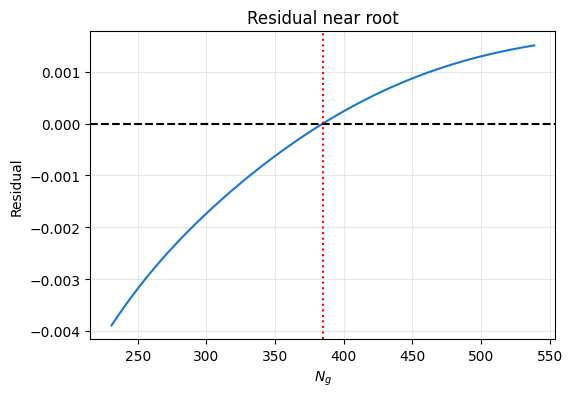

[(5e-06, 387.2090723987402),
 (1e-05, 384.873405213398),
 (2e-05, 380.2936664911057)]

In [15]:
# Residual at solution
res_at_root = residual_ng(Ng_root, params)
print(f"N_g = {Ng_root:.6g}, residual = {res_at_root:.3e}, method = {method_used}")

# Plot residual near the solution (only if finite)
if np.isfinite(Ng_root):
    x_left = max(110, Ng_root * 0.6)
    x_right = Ng_root * 1.4
    x_plot = np.linspace(x_left, x_right, 400)
    y_plot = np.array([residual_ng(x, params) for x in x_plot])

    plt.figure(figsize=(6, 4))
    plt.plot(x_plot, y_plot, color="#1B76D1")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(Ng_root, color="red", linestyle=":")
    plt.xlabel(r"$N_g$")
    plt.ylabel("Residual")
    plt.title("Residual near root")
    plt.grid(alpha=0.3)
    plt.show()

# Sensitivity: vary epsilon
eps_values = [params["epsilon"] * f for f in [0.5, 1.0, 2.0]]
sols = []
for e in eps_values:
    p2 = dict(params)
    p2["epsilon"] = e
    _, _, bracket2 = find_bracket(p2)
    if bracket2:
        sol = root_scalar(lambda x: residual_ng(x, p2), bracket=bracket2, method="brentq")
        ng_val = sol.root if sol.converged else np.nan
    else:
        sol = minimize_scalar(lambda x: abs(residual_ng(x, p2)), bounds=(110.0, 1.0e8), method="bounded")
        ng_val = sol.x if sol.success else np.nan
    sols.append((e, ng_val))

sols

## 5) Sweep $\Delta$ and Plot Optimal $N_g$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


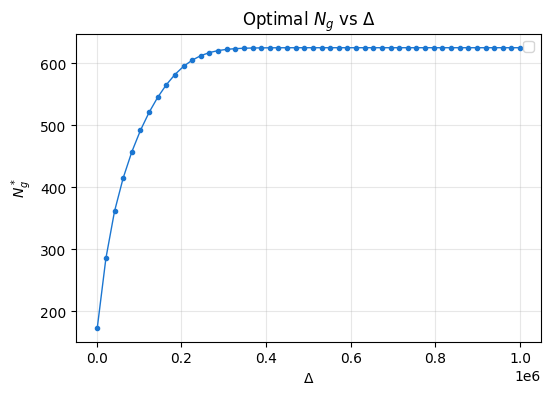

Solved points: 50/50


In [16]:
def solve_ng_for_delta(delta, p):
    p2 = dict(p)
    p2["Delta"] = float(delta)

    # Enforce physical constraint N_g <= Delta and N_g > 100
    if p2["Delta"] <= 100:
        return np.nan
    ng_min = 110.0
    ng_max = min(1.0e8, p2["Delta"])

    _, _, bracket2 = find_bracket(p2, ng_min=ng_min, ng_max=ng_max)
    if bracket2:
        sol = root_scalar(lambda x: residual_ng(x, p2), bracket=bracket2, method="brentq")
        return sol.root if sol.converged else np.nan

    # Fallback: minimize absolute residual within bounds
    sol = minimize_scalar(lambda x: abs(residual_ng(x, p2)), bounds=(ng_min, ng_max), method="bounded")
    return sol.x if sol.success else np.nan

# Sweep Delta (1000 to 1,000,000)
D_sweep = np.linspace(1.0e3, 1.0e6, 50)
Ng_sweep = np.array([solve_ng_for_delta(d, params) for d in D_sweep], dtype=float)

# Plot only finite results
mask = np.isfinite(Ng_sweep)
plt.figure(figsize=(6, 4))
plt.plot(D_sweep[mask], Ng_sweep[mask], color="#1B76D1", marker="o", markersize=3, linewidth=1)
#plt.plot(D_sweep[mask], D_sweep[mask], color="black", linestyle="--", linewidth=1, label=r"$N_g=\Delta$")
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$N_g^*$")
plt.title(r"Optimal $N_g$ vs $\Delta$")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Quick summary
nan_count = np.sum(~mask)
print(f"Solved points: {len(D_sweep) - nan_count}/{len(D_sweep)}")

## 6) Sweep $\Delta$ for Multiple $\epsilon$ Values
Plot $N_g^*(\Delta)$ for several $\epsilon$ values from the figure.

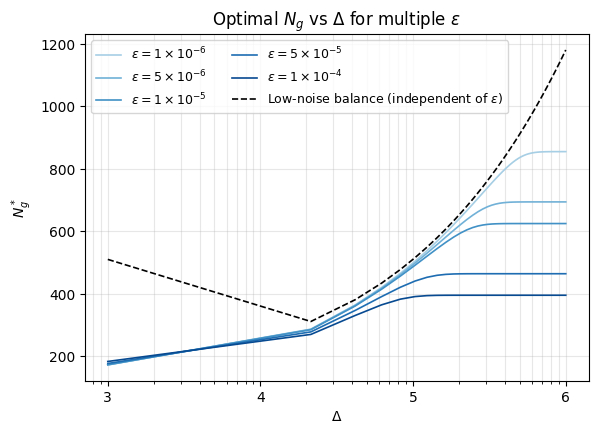

[(1e-06, 50), (5e-06, 50), (1e-05, 50), (5e-05, 50), (0.0001, 50)]

In [19]:
# Epsilon values (from the figure)
eps_list = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]

# Ensure Delta sweep exists
if "D_sweep" not in globals():
    D_sweep = np.linspace(1.0e3, 1.0e6, 50)

colors = plt.cm.Blues(np.linspace(0.35, 0.9, len(eps_list)))

plt.figure(figsize=(6.5, 4.5))
solved_counts = []

for color, eps in zip(colors, eps_list):
    p_eps = dict(params)
    p_eps["epsilon"] = eps
    Ng_eps = np.array([solve_ng_for_delta(d, p_eps) for d in D_sweep], dtype=float)
    mask = np.isfinite(Ng_eps)

    coef, exp = "{:.0e}".format(eps).split("e")
    label = rf"$\epsilon = {coef} \times 10^{{{int(exp)}}}$"
    plt.plot(D_sweep[mask], Ng_eps[mask], color=color, linewidth=1.2, label=label)

    solved_counts.append((eps, int(mask.sum())))

# Low-noise balance curve (independent of epsilon)
def balance_residual(Ng, delta, p):
    if Ng <= 100:
        return np.nan
    mu0 = p["mu0"]
    lam = p["lam"]
    alpha = p["alpha"]
    beta = p["beta"]
    kappa = p["kappa"]

    f_ng = (mu0 * delta) / (Ng * (Ng - 100) ** lam)
    lhs = alpha * np.exp(-f_ng) * (1 + lam) * mu0 * delta / (Ng ** (2 + lam))
    rhs = beta * kappa * np.exp(-kappa * Ng)
    return lhs - rhs

p_base = dict(params)
Ng_balance = []
for d in D_sweep:
    if d <= 100:
        Ng_balance.append(np.nan)
        continue
    ng_min = 110.0
    ng_max = min(1.0e8, d)

    grid = np.logspace(np.log10(ng_min), np.log10(ng_max), 200)
    res = np.array([balance_residual(x, d, p_base) for x in grid])
    bracket = None
    for i in range(len(grid) - 1):
        if np.isfinite(res[i]) and np.isfinite(res[i + 1]) and res[i] * res[i + 1] < 0:
            bracket = (grid[i], grid[i + 1])
            break

    if bracket:
        sol = root_scalar(lambda x: balance_residual(x, d, p_base), bracket=bracket, method="brentq")
        Ng_balance.append(sol.root if sol.converged else np.nan)
    else:
        sol = minimize_scalar(lambda x: abs(balance_residual(x, d, p_base)), bounds=(ng_min, ng_max), method="bounded")
        Ng_balance.append(sol.x if sol.success else np.nan)

Ng_balance = np.array(Ng_balance, dtype=float)
mask_b = np.isfinite(Ng_balance)
plt.plot(D_sweep[mask_b], Ng_balance[mask_b], color="black", linestyle="--", linewidth=1.2,
         label=r"Low-noise balance (independent of $\epsilon$)")

ax = plt.gca()
ax.set_xscale("log")
ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0))
ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=10))
ax.xaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))

plt.xlabel(r"$\Delta$")
plt.ylabel(r"$N_g^*$")
plt.title(r"Optimal $N_g$ vs $\Delta$ for multiple $\epsilon$")
plt.grid(alpha=0.3, which="both")
plt.legend(ncol=2, fontsize=9)
plt.show()

solved_counts